In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows =10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements")

Ran the import statements


In [3]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

In [4]:
# Calculate the Z-scores of each column in the training set and
# write those Z-scores into a new pandas DataFrame named train_df_norm.
train_df_mean = train_df.mean()
train_df_std = train_df.std()
train_df_norm = (train_df - train_df_mean)/train_df_std

# Examine some of the values of the normalized training set. Notice that most 
# Z-scores fall between -2 and +2.
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
1257,1.2,-1.3,-0.4,0.4,1.1,0.3,1.0,-0.9,-0.6
16091,-1.4,1.0,-0.9,-0.1,-0.1,-0.5,0.0,-0.4,-1.0
10642,-0.5,0.8,-1.0,-0.6,-0.7,-0.4,-0.7,-0.2,-0.9
2682,0.9,-0.7,-0.5,-0.5,-0.5,-0.6,-0.5,-0.5,-0.5
1831,1.1,-0.7,-0.6,-1.0,-1.0,-0.9,-1.0,-1.1,-1.1


In [5]:
# Calculate the Z-scores of each column in the test set and
# write those Z-scores into a new pandas DataFrame named test_df_norm.
test_df_mean = test_df.mean()
test_df_std  = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std

In [8]:
# We arbitrarily set the threshold to 265,000, which is 
# the 75th percentile for median house values.  Every neighborhood
# with a median house price above 265,000 will be labeled 1, 
# and all other neighborhoods will be labeled 0.
threshold = 265000
train_df_norm["median_house_value_is_high"] = (train_df["median_house_value"] > threshold).astype(float)
test_df_norm["median_house_value_is_high"] = (test_df["median_house_value"] > threshold).astype(float) 
train_df_norm["median_house_value_is_high"].head(8000)


# Alternatively, instead of picking the threshold
# based on raw house values, you can work with Z-scores.
# For example, the following possible solution uses a Z-score
# of +1.0 as the threshold, meaning that no more
# than 16% of the values in median_house_value_is_high
# will be labeled 1.

# threshold_in_Z = 1.0 
# train_df_norm["median_house_value_is_high"] = (train_df_norm["median_house_value"] > threshold_in_Z).astype(float)
# test_df_norm["median_house_value_is_high"] = (test_df_norm["median_house_value"] > threshold_in_Z).astype(float) 

1257    0.0
16091   0.0
10642   0.0
2682    0.0
1831    0.0
         ..
2143    0.0
9991    0.0
16977   0.0
6036    0.0
14719   0.0
Name: median_house_value_is_high, Length: 8000, dtype: float64

In [7]:
inputs = {
# Features used to train the model on.
  'median_income': tf.keras.Input(shape=(1,)),
  'total_rooms': tf.keras.Input(shape=(1,))
}

In [6]:
#@title Define the functions that create and train a model.
def create_model(my_inputs, my_learning_rate, METRICS):
  # Use a Concatenate layer to concatenate the input layers into a single tensor.
  # as input for the Dense layer. Ex: [input_1[0][0], input_2[0][0]]
  concatenated_inputs = tf.keras.layers.Concatenate()(my_inputs.values())
  dense = layers.Dense(units=1, input_shape=(1,),name='dense_layer', activation=tf.sigmoid)
  dense_output = dense(concatenated_inputs)
  """Create and compile a simple classification model."""
  my_outputs = {
    'dense': dense_output,
  }
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=METRICS)
  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


In [9]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/20


/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 0s 686us/step - loss: 0.6403 - accuracy: 0.4316
Epoch 2/20
170/170 [==============================] - 0s 674us/step - loss: 0.5742 - accuracy: 0.5491
Epoch 3/20
170/170 [==============================] - 0s 633us/step - loss: 0.5212 - accuracy: 0.6412
Epoch 4/20
170/170 [==============================] - 0s 799us/step - loss: 0.4791 - accuracy: 0.7097
Epoch 5/20
170/170 [==============================] - 0s 628us/step - loss: 0.4484 - accuracy: 0.7479
Epoch 6/20
170/170 [==============================] - 0s 623us/step - loss: 0.4273 - accuracy: 0.7737
Epoch 7/20
170/170 [==============================] - 0s 609us/step - loss: 0.4138 - accuracy: 0.7920
Epoch 8/20
170/170 [==============================] - 0s 675us/step - loss: 0.4058 - accuracy: 0.8015
Epoch 9/20
170/170 [==============================] - 0s 726us/step - loss: 0.4014 - accuracy: 0.8042
Epoch 10/20
170/170 [==============================] - 0s 614us/step - loss: 0.3992 - accurac

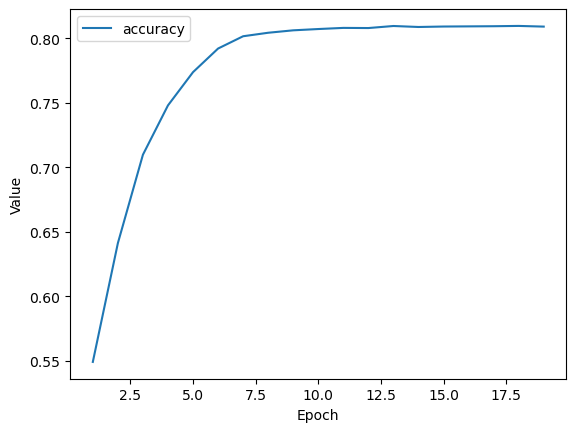

In [10]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"
classification_threshold = 0.35

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# To view a PNG of this model's layers, uncomment the call to
# `tf.keras.utils.plot_model` below. After running this code cell, click
# the file folder on the left, then the `my_classification_model.png` file.
# tf.keras.utils.plot_model(my_model, "my_classification_model.png")

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy'] 

plot_curve(epochs, hist, list_of_metrics_to_plot)

In [11]:
features = {name:np.array(value) for name, value in test_df_norm.items()}
label = np.array(features.pop(label_name))

my_model.evaluate(x = features, y = label, batch_size=batch_size)

30/30 [==============================] - 0s 663us/step - loss: 0.4069 - accuracy: 0.8010


/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


[0.4068555533885956, 0.8009999990463257]

In [ ]:
# A perfect model would make 100% accurate predictions.
# Our model makes 80% accurate predictions. 80% sounds
# good, but note that a model that always guesses 
# "median_house_value_is_high is False" would be 75% 
# accurate. 

Epoch 1/20
170/170 [==============================] - 0s 651us/step - loss: 0.5557 - accuracy: 0.5461 - precision: 0.3469 - recall: 0.9251
Epoch 2/20
170/170 [==============================] - 0s 657us/step - loss: 0.5101 - accuracy: 0.6184 - precision: 0.3855 - recall: 0.8882
Epoch 3/20
170/170 [==============================] - 0s 646us/step - loss: 0.4746 - accuracy: 0.6758 - precision: 0.4249 - recall: 0.8427
Epoch 4/20
170/170 [==============================] - 0s 659us/step - loss: 0.4479 - accuracy: 0.7151 - precision: 0.4593 - recall: 0.7928
Epoch 5/20
170/170 [==============================] - 0s 683us/step - loss: 0.4290 - accuracy: 0.7453 - precision: 0.4936 - recall: 0.7492
Epoch 6/20
170/170 [==============================] - 0s 781us/step - loss: 0.4155 - accuracy: 0.7666 - precision: 0.5245 - recall: 0.7069
Epoch 7/20
170/170 [==============================] - 0s 712us/step - loss: 0.4069 - accuracy: 0.7845 - precision: 0.5562 - recall: 0.6805
Epoch 8/20
170/170 [=======

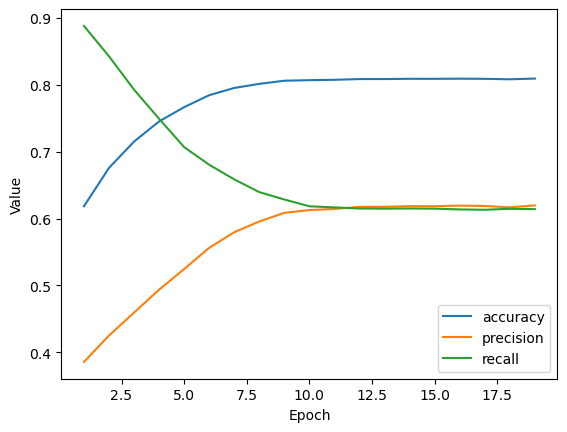

In [12]:
#@title Double-click to view the solution for Task 3.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.35
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)


# The new graphs suggest that precision and recall are 
# somewhat in conflict. That is, improvements to one of
# those metrics may hurt the other metric.

Epoch 1/20


/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 0s 709us/step - loss: 0.6311 - accuracy: 0.7318 - precision: 0.4744 - recall: 0.6793
Epoch 2/20
170/170 [==============================] - 0s 682us/step - loss: 0.5770 - accuracy: 0.7524 - precision: 0.5033 - recall: 0.6555
Epoch 3/20
170/170 [==============================] - 0s 668us/step - loss: 0.5312 - accuracy: 0.7720 - precision: 0.5373 - recall: 0.6299
Epoch 4/20
170/170 [==============================] - 0s 691us/step - loss: 0.4922 - accuracy: 0.7882 - precision: 0.5721 - recall: 0.6044
Epoch 5/20
170/170 [==============================] - 0s 966us/step - loss: 0.4607 - accuracy: 0.8007 - precision: 0.6071 - recall: 0.5733
Epoch 6/20
170/170 [==============================] - 0s 791us/step - loss: 0.4366 - accuracy: 0.8131 - precision: 0.6509 - recall: 0.5430
Epoch 7/20
170/170 [==============================] - 0s 880us/step - loss: 0.4185 - accuracy: 0.8219 - precision: 0.6924 - recall: 0.5168
Epoch 8/20
170/170 [==================

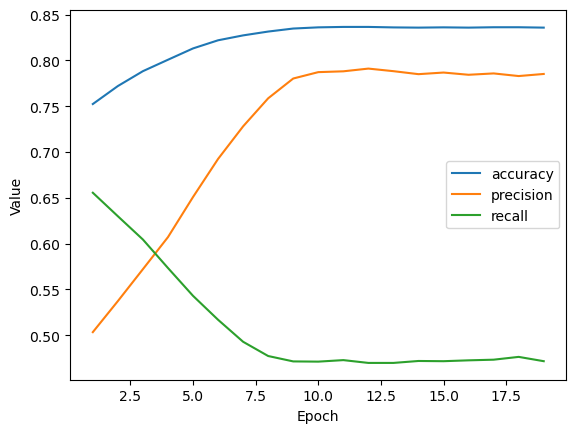

In [13]:
#@title Double-click to view the solution for Task 4.

# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
classification_threshold = 0.52
label_name = "median_house_value_is_high"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                      threshold=classification_threshold),
      tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision' 
                                 ),
      tf.keras.metrics.Recall(thresholds=classification_threshold,
                              name="recall"),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall"] 
plot_curve(epochs, hist, list_of_metrics_to_plot)

# A `classification_threshold` of slightly over 0.5
# appears to produce the highest accuracy (about 83%).
# Raising the `classification_threshold` to 0.9 drops 
# accuracy by about 5%.  Lowering the 
# `classification_threshold` to 0.3 drops accuracy by 
# about 3%. 

Epoch 1/20
  1/170 [..............................] - ETA: 33s - loss: 0.8222 - auc: 0.1679

/home/franksitawa/anaconda3/lib/python3.10/site-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['longitude', 'latitude', 'housing_median_age', 'total_bedrooms', 'population', 'households', 'median_house_value'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


170/170 [==============================] - 0s 919us/step - loss: 0.7613 - auc: 0.1752
Epoch 2/20
170/170 [==============================] - 0s 651us/step - loss: 0.6714 - auc: 0.2146
Epoch 3/20
170/170 [==============================] - 0s 681us/step - loss: 0.6008 - auc: 0.6392
Epoch 4/20
170/170 [==============================] - 0s 646us/step - loss: 0.5456 - auc: 0.7965
Epoch 5/20
170/170 [==============================] - 0s 655us/step - loss: 0.5033 - auc: 0.8193
Epoch 6/20
170/170 [==============================] - 0s 659us/step - loss: 0.4712 - auc: 0.8270
Epoch 7/20
170/170 [==============================] - 0s 661us/step - loss: 0.4475 - auc: 0.8320
Epoch 8/20
170/170 [==============================] - 0s 675us/step - loss: 0.4305 - auc: 0.8344
Epoch 9/20
170/170 [==============================] - 0s 683us/step - loss: 0.4186 - auc: 0.8355
Epoch 10/20
170/170 [==============================] - 0s 656us/step - loss: 0.4101 - auc: 0.8357
Epoch 11/20
170/170 [===================

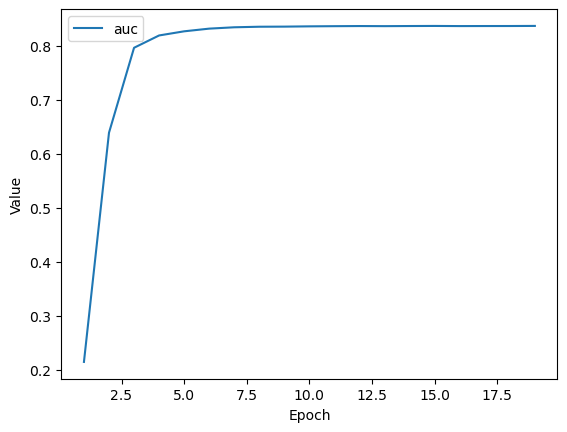

In [14]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 20
batch_size = 100
label_name = "median_house_value_is_high"

# AUC is a reasonable "summary" metric for 
# classification models.
# Here is the updated definition of METRICS to 
# measure AUC:
METRICS = [
      tf.keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
my_model = create_model(inputs, learning_rate, METRICS)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size)

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['auc'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)